#Assignment 4

AADHYA ENLLAWAR, 21BCE8096, VIT_AP

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

#Task 1
Load the Dataset

In [3]:
df = pd.read_csv("winequality-red.csv")
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


#Task 2
Data Preprocessing includind Visualization

In [6]:
missing_values = df.isnull().sum()
print(missing_values)
df.fillna(df.mean(), inplace=True)

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


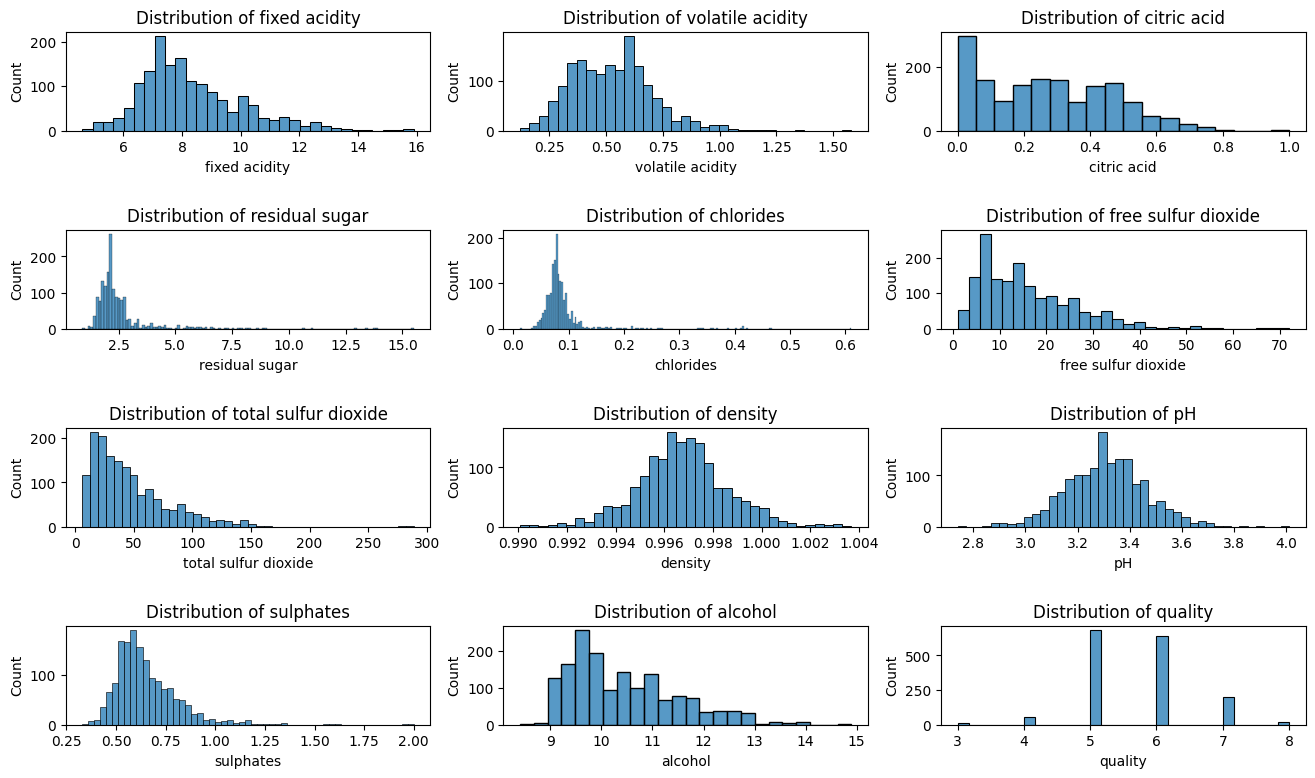

In [7]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16, 9))
plt.subplots_adjust(hspace=1)
for ax, col in zip(axes.flat, df.columns):
    sns.histplot(data=df, x=col, ax=ax)
    ax.set_title(f"Distribution of {col}")
plt.show()

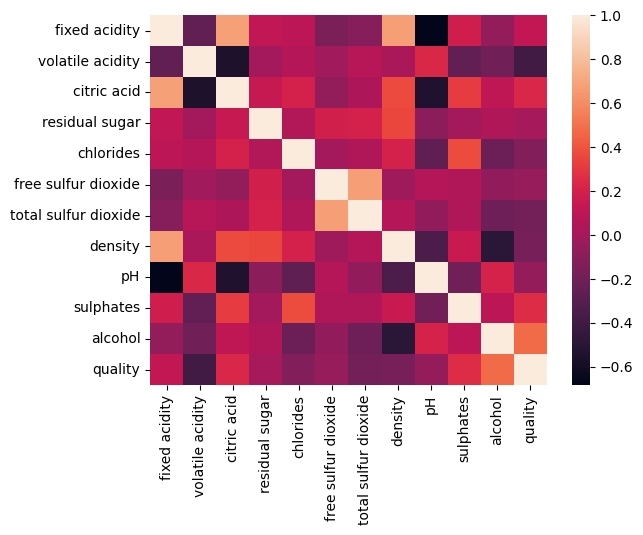

In [8]:
ax = sns.heatmap(df.corr(numeric_only=True))
plt.show()

Feature Engineering

In [10]:
df["quality category"] = df["quality"].astype("category")

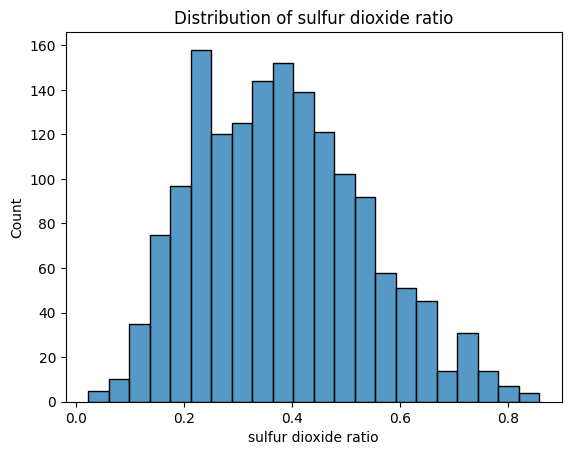

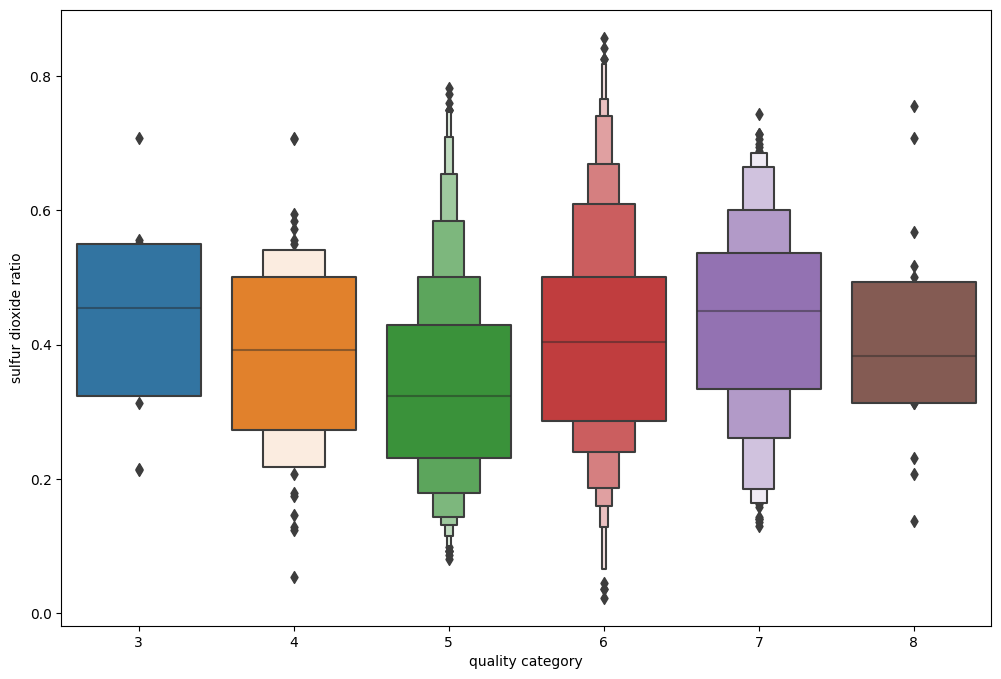

In [11]:
df["sulfur dioxide ratio"] = df["free sulfur dioxide"] / df["total sulfur dioxide"]
ax = sns.histplot(data=df, x="sulfur dioxide ratio")
ax.set_title(f"Distribution of sulfur dioxide ratio")
plt.show()
plt.figure(figsize=(12,8))
ax = sns.boxenplot(data=df, y="sulfur dioxide ratio", x="quality category")
plt.show()

#Task 3
Machine Learning Model Building

In [12]:
explanatory_cols = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'sulfur dioxide ratio', 'density', 'pH', 'sulphates', 'alcohol']
response_col = ['quality']
X = df[explanatory_cols]
y = df[response_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (1279, 10)
Shape of y_train: (1279, 1)
Shape of X_test: (320, 10)
Shape of y_test: (320, 1)


In [13]:
models = [
    ('random_forest', RandomForestRegressor()),
    ('gradient_boosting', GradientBoostingRegressor()),
    ('hist_gradient_boosting', HistGradientBoostingRegressor()),
    ('svr', SVR()),
    ('k_neighbors', KNeighborsRegressor())
]

In [14]:
def create_pipeline(name, model):
    return Pipeline([
        ('scaler', StandardScaler()),
        (name, model)
    ])
n_splits = 4
skf = StratifiedKFold(n_splits = n_splits, shuffle=True)
best_loss = np.inf
best_model_name = None
for name, model in models:
    print("-"*25)
    print(f"Training MODEL {name}")
    print("-"*25)
    val_losses = []
    for i, (train_index, val_index) in enumerate(skf.split(X_train, y_train)):
        print(f"Training on FOLD {i+1}")
        X_train_act = X_train.iloc[train_index].values
        X_val = X_train.iloc[val_index].values
        y_train_act = y_train.iloc[train_index].values.ravel()
        y_val = y_train.iloc[val_index].values.ravel()
        pipe = create_pipeline(name, model)
        pipe.fit(X_train_act, y_train_act)
        y_val_pred = pipe.predict(X_val)
        mse = mean_squared_error(y_val, y_val_pred)
        print(f"MSE on validation set: {mse}")
        print()
        val_losses.append(mse)
    average_loss = np.mean(val_losses)
    print(f"Average MSE: {average_loss}")
    if average_loss < best_loss:
        best_loss = average_loss
        best_model_name = name
print()
print(f"Best model: {best_model_name}")
print(f"MSE: {best_loss}")

-------------------------
Training MODEL random_forest
-------------------------
Training on FOLD 1
MSE on validation set: 0.3462146875

Training on FOLD 2
MSE on validation set: 0.3801140625

Training on FOLD 3
MSE on validation set: 0.37174874999999996

Training on FOLD 4
MSE on validation set: 0.37542319749216296

Average MSE: 0.36837517437304074
-------------------------
Training MODEL gradient_boosting
-------------------------
Training on FOLD 1
MSE on validation set: 0.37884589990036643

Training on FOLD 2
MSE on validation set: 0.4302725563631508

Training on FOLD 3
MSE on validation set: 0.4216035474540508

Training on FOLD 4
MSE on validation set: 0.4707972384635643

Average MSE: 0.4253798105452831
-------------------------
Training MODEL hist_gradient_boosting
-------------------------
Training on FOLD 1
MSE on validation set: 0.3933813650304209

Training on FOLD 2
MSE on validation set: 0.3986072428733241

Training on FOLD 3
MSE on validation set: 0.41803623121210914

Train

Hyperparameter Tuning

In [16]:
models_dict = dict(models)
best_model = models_dict[best_model_name]
pipeline = create_pipeline(best_model_name, best_model)
parameters_grid = {
    f"random_forest__n_estimators": [30, 50, 100, 200],
    f"random_forest__max_depth": [None, 4, 6],
    f"random_forest__max_features": [None, "sqrt", "log2"]
}
search = GridSearchCV(pipeline, parameters_grid)
search.fit(X_train, y_train.values.ravel())

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('random_forest',
                                        RandomForestRegressor())]),
             param_grid={'random_forest__max_depth': [None, 4, 6],
                         'random_forest__max_features': [None, 'sqrt', 'log2'],
                         'random_forest__n_estimators': [30, 50, 100, 200]})

In [17]:
search.best_params_

{'random_forest__max_depth': None,
 'random_forest__max_features': 'log2',
 'random_forest__n_estimators': 200}

#Task 4
Evaluate the Model

In [18]:
best_pipeline = search.best_estimator_

In [19]:
y_pred = best_pipeline.predict(X_test)
print(f"MSE for test dataset: {mean_squared_error(y_pred, y_test)}")

MSE for test dataset: 0.307600078125


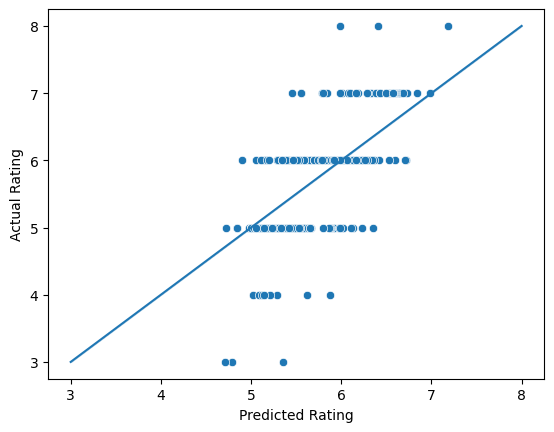

In [20]:
flat_y_test = y_test.values.flatten()
ax = sns.scatterplot(x=y_pred, y=flat_y_test)
sns.lineplot(x=flat_y_test, y=flat_y_test, ax=ax)
ax.set_xlabel("Predicted Rating")
ax.set_ylabel("Actual Rating")
plt.show()

#Task 5
Test with Random Observation

In [25]:
random_observation = {
    'fixed acidity': 7.1,
    'volatile acidity': 0.52,
    'citric acid': 0.14,
    'residual sugar': 2.54,
    'chlorides': 0.06,
    'sulfur dioxide ratio': 0.4,
    'density': 0.996,
    'pH': 3.2,
    'sulphates': 0.6,
    'alcohol': 9.0
}
random_observation_df = pd.DataFrame([random_observation])

In [26]:
predicted_quality = best_pipeline.predict(random_observation_df)
print("Predicted Quality:", predicted_quality[0])

Predicted Quality: 5.495
